In [1]:
!pip install image-quality


In [2]:
!pip install tensorflow_hub

In [1]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [2]:

SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [3]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [4]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [26]:
hr_image = preprocess_image("baboonlow.png")

Saved as Original Image.jpg


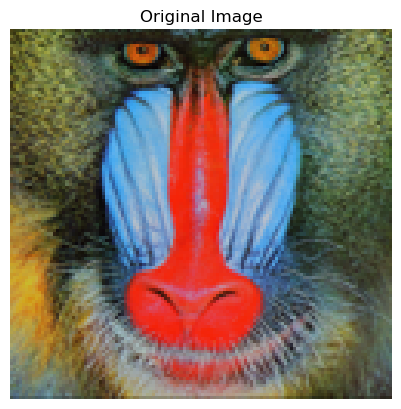

In [27]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [7]:
model = hub.load(SAVED_MODEL_PATH)

In [28]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 0.598315


Saved as SuperResolution.jpg


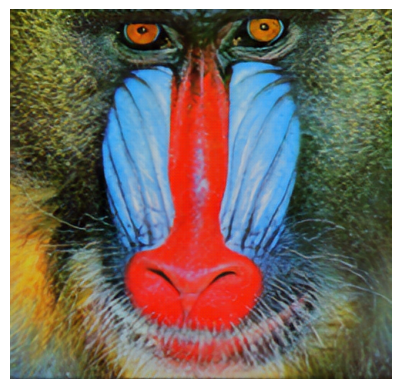

In [29]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image))
save_image(tf.squeeze(fake_image), filename="SuperResolution")

In [35]:
import cv2
import numpy as np

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

# Read PNG image
png_img = cv2.imread('baboonlow.png')

# Read JPEG image
jpeg_img = cv2.imread('SuperResolution.jpg')

# Resize images to a common size
# Choose the desired dimensions for resizing
common_size = (256, 256)
png_resized = cv2.resize(png_img, common_size)
jpeg_resized = cv2.resize(jpeg_img, common_size)

# Convert images to grayscale if needed
png_gray = cv2.cvtColor(png_resized, cv2.COLOR_BGR2GRAY)
jpeg_gray = cv2.cvtColor(jpeg_resized, cv2.COLOR_BGR2GRAY)

# Calculate PSNR
psnr_png_vs_jpeg = psnr(png_gray, jpeg_gray)
print("PSNR :", psnr_png_vs_jpeg)


PSNR : 29.990137390859573
